# A2.5 Multilayer Neural Networks for Nonlinear Regression


*Joshua Tyndale*

## Summary

In this assignment you will 
* make some modifications to the supplied neural network implementation, 
* define a function that partitions data into training, validation and test sets,
* apply it to a data set, 
* define a function that runs experiments with a variety of parameter values, 
* describe your observations of these results.

## Optimizers

First, we need a class that includes our optimization algorithms, `sgd` and `adam`.  The following code cell implements `sgd`.  You must complete the implementation of `adam`, following its implementation in the lecture notes.

Notice that `all_weights` is updated in place by these optimization algorithms.  The new values of `all_weights` are not returned from these functions, because the code that calls these functions allocates the memory for `all_weights` and keeps the reference to it so has direct access to the new values.

In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights

        # The following initializations are only used by adam.
        # Only initializing mt, vt, beta1t and beta2t here allows multiple calls to adam to handle training
        # with multiple subsets (batches) of training data.
        self.mt = np.zeros_like(all_weights)
        self.vt = np.zeros_like(all_weights)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.beta1t = 1  # was self.beta1
        self.beta2t = 1  # was self.beta2

        
    def sgd(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= learning_rate * grad

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if (epoch + 1) % max(1, epochs_per_print) == 0:
                print(f'sgd: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

    def adam(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)
 
            #.append Finish Adam implementation here by updating
            #   self.mt
            self.mt = self.beta1 * self.mt + (1 - self.beta1) * grad #past propogations + current
            #   self.vt
            self.vt = self.beta2 * self.vt + (1 - self.beta2) * np.square(grad)
            #   self.beta1t
            self.beta1t *= self.beta1             # bias corrected moment estimates
            #   self.beta2t
            self.beta2t *= self.beta2
            # and updating values of self.all_weights (backwards pass)
            
            self.mhat = self.mt / (1 - self.beta1t )
            self.vhat = self.vt / (1 - self.beta2t )               
            self.all_weights -= alpha * self.mhat / (np.sqrt(self.vhat) + epsilon)
            
            

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if (epoch + 1) % max(1, epochs_per_print) == 0:
                print(f'Adam: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace
    

Test `Optimizers` using the function `test_optimizers`.  You should get the same results shown below.

In [28]:
def test_optimizers():

    def parabola(wmin):
        return ((w - wmin) ** 2)[0]

    def parabola_gradient(wmin):
        return 2 * (w - wmin)

    w = np.array([0.0])
    optimizer = Optimizers(w)

    wmin = 5
    optimizer.sgd(parabola, parabola_gradient, [wmin], n_epochs=100, learning_rate=0.1)
    print(f'sgd: Minimum of parabola is at {wmin}. Value found is {w}')

    w = np.array([0.0])
    optimizer = Optimizers(w)
    optimizer.adam(parabola, parabola_gradient, [wmin], n_epochs=100, learning_rate=0.1)
    print(f'adam: Minimum of parabola is at {wmin}. Value found is {w}')

In [29]:
test_optimizers()

sgd: Epoch 10 Error=0.45036
sgd: Epoch 20 Error=0.00519
sgd: Epoch 30 Error=0.00006
sgd: Epoch 40 Error=0.00000
sgd: Epoch 50 Error=0.00000
sgd: Epoch 60 Error=0.00000
sgd: Epoch 70 Error=0.00000
sgd: Epoch 80 Error=0.00000
sgd: Epoch 90 Error=0.00000
sgd: Epoch 100 Error=0.00000
sgd: Minimum of parabola is at 5. Value found is [5.]
Adam: Epoch 10 Error=16.85565
Adam: Epoch 20 Error=9.93336
Adam: Epoch 30 Error=5.21627
Adam: Epoch 40 Error=2.37740
Adam: Epoch 50 Error=0.90515
Adam: Epoch 60 Error=0.26972
Adam: Epoch 70 Error=0.05453
Adam: Epoch 80 Error=0.00453
Adam: Epoch 90 Error=0.00016
Adam: Epoch 100 Error=0.00147
adam: Minimum of parabola is at 5. Value found is [5.03900403]


## NeuralNetwork class

Now we can implement the `NeuralNetwork` class that calls the above `Optimizers` functions to update the weights.

You must first complete the `use` function.  You can make use of the `forward_pass` function.

In [30]:
class NeuralNetwork():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs})'


    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        if self.trained:
            return self.__repr__() + f' trained for {self.total_epochs} epochs, final training error {self.error_trace[-1]}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd'):
        '''
train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units.
        error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self

   
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        for W in self.Ws[:-1]:
            self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

    def use(self, X):
        '''X assumed to not be standardized. Return the unstandardized prediction
        . You can make use of the forward_pass function.
        
        #First, standardize data
        '''
        X = (X - self.Xmeans) / self.Xstds
        
        '''
        #use neural network
        #Training and using phases
        #use: put inputs in, do forward pass, evaluate outputs
        #train: forward pass -> prediction. compare prediction to target value (T) how close are they? = error
            #back propigation to make your error smaller (plug the error in back propogation)
        '''
        predictions = self.forward_pass(X) #self.?
        
        
        '''
        #unstandardize data before it goes out
        T = (T - self.Tmeans) / self.Tstds
        '''
        #print(predictions[-1])
        #print("---------------------------------------------------------------------")
        #print(self.Tstds)
        
        predictions = ((predictions[-1] * self.Tstds) + self.Tmeans) #multiply Xstandards and add Xmeans (opposite of standardizing)
        
        
        return predictions


Then test it with the `test_neuralnetwork` function.  Your results should be the same as those shown, because the pseudo-random number generator used to initialize the weights is set to start with the same seed.

In [31]:
np.random.seed(42)
np.random.uniform(-0.1, 0.1, size=(2, 2))

array([[-0.02509198,  0.09014286],
       [ 0.04639879,  0.0197317 ]])

In [32]:
np.random.uniform(-0.1, 0.1, size=(2, 2))

array([[-0.06879627, -0.0688011 ],
       [-0.08838328,  0.07323523]])

In [33]:
np.random.seed(42)
np.random.uniform(-0.1, 0.1, size=(2, 2))

array([[-0.02509198,  0.09014286],
       [ 0.04639879,  0.0197317 ]])

In [34]:
def test_neuralnetwork():
    
    np.random.seed(42)
    
    X = np.arange(100).reshape((-1, 1))
    T = np.sin(X * 0.04)

    n_hiddens = [10, 10]
    n_epochs = 2000
    learning_rate = 0.01
    
    nnetsgd = NeuralNetwork(1, n_hiddens, 1)
    nnetsgd.train(X, T, n_epochs, learning_rate, method='sgd')

    print()  # skip a line
    
    nnetadam = NeuralNetwork(1, n_hiddens, 1)
    nnetadam.train(X, T, n_epochs, learning_rate, method='adam')

    Ysgd = nnetsgd.use(X)
    Yadam = nnetadam.use(X)

    plt.figure(figsize=(15,10))
    plt.subplot(1, 3, 1)
    plt.plot(nnetsgd.error_trace, label='SGD')
    plt.plot(nnetadam.error_trace, label='Adam')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(T, Ysgd, 'o', label='SGD')
    plt.plot(T, Yadam, 'o', label='Adam')
    a = min(np.min(T), np.min(Ysgd))
    b = max(np.max(T), np.max(Ysgd))
    plt.plot([a, b], [a, b], 'k-', lw=3, alpha=0.5, label='45 degree')
    plt.xlabel('Target')
    plt.ylabel('Predicted')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(Ysgd, 'o-', label='SGD')
    plt.plot(Yadam, 'o-', label='Adam')
    plt.plot(T, label='Target')
    plt.xlabel('Sample')
    plt.ylabel('Target or Predicted')
    plt.legend()

    plt.tight_layout()

sgd: Epoch 200 Error=0.49330
sgd: Epoch 400 Error=0.46833
sgd: Epoch 600 Error=0.44525
sgd: Epoch 800 Error=0.42264
sgd: Epoch 1000 Error=0.39428
sgd: Epoch 1200 Error=0.35526
sgd: Epoch 1400 Error=0.30300
sgd: Epoch 1600 Error=0.24079
sgd: Epoch 1800 Error=0.18020
sgd: Epoch 2000 Error=0.13423

Adam: Epoch 200 Error=0.11620
Adam: Epoch 400 Error=0.00795
Adam: Epoch 600 Error=0.00362
Adam: Epoch 800 Error=0.00268
Adam: Epoch 1000 Error=0.00236
Adam: Epoch 1200 Error=0.00213
Adam: Epoch 1400 Error=0.00201
Adam: Epoch 1600 Error=0.00184
Adam: Epoch 1800 Error=0.00169
Adam: Epoch 2000 Error=0.00163


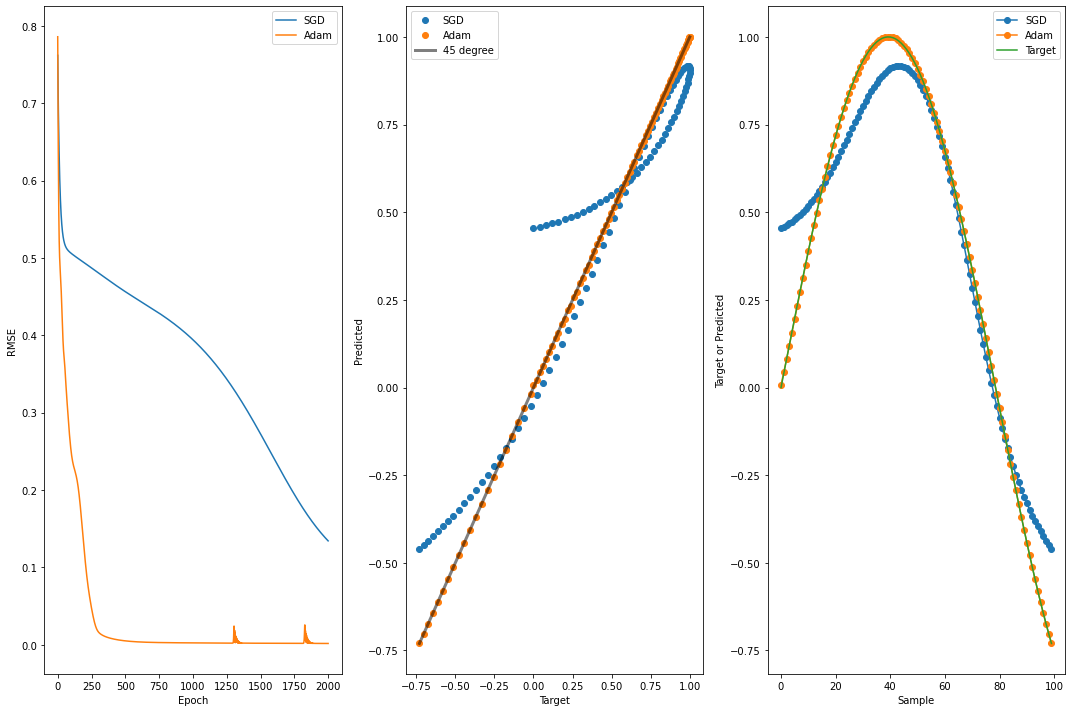

In [35]:
test_neuralnetwork()

## ReLU Activation Function

Cut and paste your `NeuralNetwork` class cell here.  Then modify it to allow the use of the ReLU activiation function, in addition to the `tanh` activation function that `NeuralNetwork` currently uses.  

Do this by
* Add the argument `activation_function` to the `NeuralNetwork` constructor that can be given values of `tanh` or `relu`, with `tanh` being its default value.
* Define two new class functions, `relu(s)` that accepts a matrix of weighted sums and returns the ReLU values, and `grad_relu(s)` that returns the gradient of `relu(s)` with respect to each value in `s`.
* Add `if` statements to `forward_pass` and `gradient_f` to selectively use the `tanh` or `relu` activation function. This is easy if you assign a new class variable in the `NeuralNetwork` constructor that has the value of the argument `activation_function`.

In [36]:
class NeuralNetwork():

    #(1 - self.Ys[layeri] ** 2)    this is the derivative of tanh

    
    def relu(self, s):
        #accepts a matrix of weighted sums and returns the ReLU values, 
        #return ReLU_values
        return np.maximum(0, s)
    
    def grad_relu(self, s):
        #returns the gradient of relu(s) with respect to each value in s
        #return gradient_ReLU
        return np.heaviside(s, 1)
    

    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function="tanh"):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        #assign a new class variable in the NeuralNetwork constructor that has the value of the argument activation_function
        self.activation_function = activation_function

        
        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs})'


    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        if self.trained:
            return self.__repr__() + f' trained for {self.total_epochs} epochs, final training error {self.error_trace[-1]}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd'):
        '''
train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units.
        error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self

   
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        for W in self.Ws[:-1]:
            if(self.activation_function == "relu"):
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            if(self.activation_function == "tanh"):
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])     
        return self.Ys #Y is prediction

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            

            #selectively use the tanh or relu activation function.
            if(self.activation_function == "relu"):
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(layeri)
            if(self.activation_function == "tanh"):
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)#this is tanh
            
        return self.all_gradients

    def use(self, X):
        '''X assumed to not be standardized. 
        Return the unstandardized prediction.
        You can make use of the forward_pass function.
        '''
        
        #First, standardize data
        X = (X - self.Xmeans) / self.Xstds
        
        '''  
        #Training and using phases
        #use: put inputs in, do forward pass, evaluate outputs
        #train: forward pass -> prediction. compare prediction to target value (T) how close are they? = error
            #back propigation to make your error smaller (plug the error in back propogation)
        '''
        #use neural network        
        predictions = self.forward_pass(X) #self.?

        #unstandardize data before it goes out
        predictions = ((predictions[-1] * self.Tstds) + self.Tmeans) #multiply Xstandards and add Xmeans (opposite of standardizing)
        
        return predictions

    def RMSE(self, predictions, targets):
        rmseTrain = np.sqrt(np.mean((predictions - targets)**2, axis=0))
        return np.sum(rmseTrain)
        

## Now for the Experiments!

Now that your code is working, let's apply it to some interesting data.

Read in the `auto-mpg.data` that we have used in lectures.  Let's apply neural networks to predict `mpg` using various neural network architectures, numbers of epochs, and our two activation functions.

This time we will partition the data into five parts after randomly rearranging the samples.  We will assign the first partition as the validation set, the second one as the test set, and the remaining parts will be vertically stacked to form the training set, as discussed in lecture.  We can use the RMSE on the validation set to pick the best values of the number of epochs and the network architecture.  Then to report on the RMSE we expect on new data, we will report the test set RMSE.

In [37]:
import pandas # to help with reading csv file with missing values
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names
df = pandas.read_csv('auto-mpg.data-original')
df

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32149  100 32149    0     0  34020      0 --:--:-- --:--:-- --:--:-- 33984
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1660  100  1660    0     0   1939      0 --:--:-- --:--:-- --:--:--  1936


,"18.0 8. 307.0 130.0 3504. 12.0 70. 1.\t""chevrolet chevelle malibu"""
0,15.0 8. 350.0 165.0 3693. 1...
1,18.0 8. 318.0 150.0 3436. 1...
2,16.0 8. 304.0 150.0 3433. 1...
3,17.0 8. 302.0 140.0 3449. 1...
4,15.0 8. 429.0 198.0 4341. 1...
...,...
400,27.0 4. 140.0 86.00 2790. 1...
401,44.0 4. 97.00 52.00 2130. 2...
402,32.0 4. 135.0 84.00 2295. 1...
403,28.0 4. 120.0 79.00 2625. 1...


Read in the `auto-mpg.data` using `pandas` and remove all samples that contain missing values.  You should end up with 392 samples.

Now randomly reorder the samples.  First run `np.random.seed(42)` to guarantee that we all use the same random ordering of samples.

Partition the data into five folds, as shown in lecture.  To do this, complete the following function.

In [38]:
df = pandas.read_csv('auto-mpg.data-original', header=None, delim_whitespace=True, na_values='?')
df.dropna()
df.isna().sum() # detect missing values
df = df.dropna()
df.isna().sum()
df.columns
names =  ['mpg','cylinders','displacement','horsepower','weight',
          'acceleration','year','origin', 'model']
#names
df.columns = names
data = df.values
data = df.iloc[:, :-1].values # view everything except the car names (last column)
df.sum() # detect missing values

# computing number of rows 
rows = len(df.axes[0]) 
# computing number of columns 
cols = len(df.axes[1]) 
  
#print(df) 
#print("Number of Rows: ", rows) 
#print("Number of Columns: ", cols)

Xnames = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']
X = df[Xnames].to_numpy()
#X = X[:-1]
T = df[["mpg"]].to_numpy() #1:len(df['tave']), ['tave']]
print(X)
print(T)

#X=X[1:]
#T=T[1:]



[[  8.  307.  130.  ...  12.   70.    1. ]
 [  8.  350.  165.  ...  11.5  70.    1. ]
 [  8.  318.  150.  ...  11.   70.    1. ]
 ...
 [  4.  135.   84.  ...  11.6  82.    1. ]
 [  4.  120.   79.  ...  18.6  82.    1. ]
 [  4.  119.   82.  ...  19.4  82.    1. ]]
[[18. ]
 [15. ]
 [18. ]
 [16. ]
 [17. ]
 [15. ]
 [14. ]
 [14. ]
 [14. ]
 [15. ]
 [15. ]
 [14. ]
 [15. ]
 [14. ]
 [24. ]
 [22. ]
 [18. ]
 [21. ]
 [27. ]
 [26. ]
 [25. ]
 [24. ]
 [25. ]
 [26. ]
 [21. ]
 [10. ]
 [10. ]
 [11. ]
 [ 9. ]
 [27. ]
 [28. ]
 [25. ]
 [19. ]
 [16. ]
 [17. ]
 [19. ]
 [18. ]
 [14. ]
 [14. ]
 [14. ]
 [14. ]
 [12. ]
 [13. ]
 [13. ]
 [18. ]
 [22. ]
 [19. ]
 [18. ]
 [23. ]
 [28. ]
 [30. ]
 [30. ]
 [31. ]
 [35. ]
 [27. ]
 [26. ]
 [24. ]
 [25. ]
 [23. ]
 [20. ]
 [21. ]
 [13. ]
 [14. ]
 [15. ]
 [14. ]
 [17. ]
 [11. ]
 [13. ]
 [12. ]
 [13. ]
 [19. ]
 [15. ]
 [13. ]
 [13. ]
 [14. ]
 [18. ]
 [22. ]
 [21. ]
 [26. ]
 [22. ]
 [28. ]
 [23. ]
 [28. ]
 [27. ]
 [13. ]
 [14. ]
 [13. ]
 [14. ]
 [15. ]
 [12. ]
 [13. ]
 [13. ]


In [39]:
np.random.seed(42)

In [40]:
def partition(X, T, n_folds, random_shuffle=True):

    print(X.shape, T.shape)
    #Partition the data into five folds, as shown in lecture. 
    '''   Before trying to fit this data with our neural network model,
          let's discuss how to partition data into training, validation and testing. 
          Steps involved are:
            shuffle the samples into a random order,
            partition the data into n folds,
            assign the first fold to the validation set,
            assign the second fold to the testing set, and
            collect the third through the last folds into a training set.
    '''

    rows = np.arange(X.shape[0])
    np.random.shuffle(rows)  # shuffle the row indices in-place (rows is changed)
    #np.random.seed(42)
    X = X[rows, :]
    T = T[rows, :]

    #n_folds = 5
    n_samples = X.shape[0]
    n_per_fold = n_samples // n_folds # double-slash = "floor division" which rounds down to the nearest number
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)  # handles case when n_samples not evenly divided by n_folds

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )   # Changed in notes 07.2
    print(len(folds), len(folds[0]), folds[0][0].shape, folds[0][1].shape)
    #------------------------------------------------------------------
    Xvalidate, Tvalidate = folds[0]
    Xtest, Ttest = folds[1]
    Xtrain, Ttrain = np.vstack([X for (X, _) in folds[2:]]), np.vstack([T for (_, T) in folds[2:]]) # what is this doing? Hint: look at [2:]
    #print(Xtrain.shape, Ttrain.shape, Xvalidate.shape, Tvalidate.shape, Xtest.shape, Ttest.shape)

    
    return Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

Write a function named `run_experiment` that uses three nested for loops to try different values of the parameters `n_epochs`, `n_hidden_units_per_layer` and `activation_function` which will just be either `tanh` or `relu`. Don't forget to try `[0]` for one of the values of `n_hidden_units_per_layer` to include a linear model in your tests.  For each set of parameter values, create and train a neural network using the 'adam' optimization method and use the neural network on the training, validation and test sets.  Collect the parameter values and the RMSE for the training, validation, and test set in a list.  When your loops are done, construct a `pandas.DataFrame` from the list of results, for easy printing.  The first five lines might look like:

```
   epochs        nh    lr act func  RMSE Train  RMSE Val  RMSE Test
0    1000       [0]  0.01     tanh    3.356401  3.418705   3.116480
1    1000       [0]  0.01     relu    3.354528  3.428324   3.125064
2    1000      [20]  0.01     tanh    1.992509  2.355746   2.459506
3    1000      [20]  0.01     relu    2.448536  2.026954   2.581707
4    1000  [20, 20]  0.01     tanh    1.518916  2.468188   3.118376
```
Your function must return a `pandas.DataFrame` like this one.

Before starting the nested for loops, your `run_experiment` function must first call your `partition` function to form the training, validation and test sets.

In [41]:
def run_experiment(X, T, n_folds, n_epochs_choices, n_hidden_units_per_layer_choices, 
                   activation_function_choices):
    
    #Before starting the nested for loops, your `run_experiment` function must first 
    #call your `partition` function to form the training, validation and test sets.

    #results = pandas.DataFrame(columns=['epochs', 'nh', 'lr', 'act func', 
    #                                'RMSE Train', 'RMSE Val', 'RMSE Test'])
    
    results = []
    
    np.random.seed(42)
    Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest = partition(X, T, 3)
    
    #uses three nested for loops to try different values of the parameters 
    #`n_epochs`, `n_hidden_units_per_layer` and `activation_function` which will just be either 
    #`tanh` or `relu`
    for n_epochs in n_epochs_choices:
        for nh in n_hidden_units_per_layer_choices: #try [0] here to inlcude linear model in your tests
            for af in activation_function_choices:    #will be either tanh or relu
                #For each set of parameter values:
                #create and train a neural network using the 'adam' optimization method 
                #use the neural network on the training, validation and test sets.
                
                #n_hiddens = [10, 10] #i think this is nh? right?
                #n_epochs = 2000 #i think this is n_epochs_choices
                learning_rate = 0.001
                
                #overfitting can happen, need to account for. Gets used to data it sees over and over again

                #call with training data   #test against 'test data' 
                #->do this to avoid overfitting
                #nnet = NeuralNetwork(1, nh, 1, af)
                nnet = NeuralNetwork(Xtrain.shape[1], nh, Ttrain.shape[1], af)
                nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam')
                #Validation is like a second testing data set
                

                '''           
                Xtraining_adam = nnet.use(Xtrain)
                Xvalidation_adam = nnet.use(Xvalidate)
                Xtest_adam = nnet.use(Xtest) #returns matrix same size as targets (matrix of predictions)
                
                #look at RMSE between X and T
                #RMSE_test = nnet.RMSE(Xtest_adam, Ttest)
                #RMSE_train = nnet.RMSE(Xtraining_adam, Ttrain)
                #RMSE_validation = nnet.RMSE(Xvalidation_adam, Tvalidate)
                
                RMSE_train = nnet.RMSE(Ttrain, Xtraining_adam)
                RMSE_validation = nnet.RMSE(Tvalidate, Xvalidation_adam)
                RMSE_test = nnet.RMSE(Ttest, Xtest_adam)

                #Collect the parameter values and the RMSE for the 
                #training, validation, and test set in a list
                #    results = pandas.DataFrame(columns=['epochs', 'nh', 'lr', 'act func', 
                                    #'RMSE Train', 'RMSE Val', 'RMSE Test'])
                results.append([n_epochs, nh, learning_rate, af, 
                                   RMSE_train, 
                                   RMSE_validation, 
                                   RMSE_test])        
                '''
                

                results.append([n_epochs, nh, learning_rate, af, 
                                nnet.RMSE(Ttrain, nnet.use(Xtrain)),
                                nnet.RMSE(Tvalidate, nnet.use(Xvalidate)),
                                nnet.RMSE(Ttest, nnet.use(Xtest))])
                
                df = pandas.DataFrame(results, columns=('n_epochs', 'nh', 'learning_rate', 'af', 'RMSE Train', 'RMSE Val', 'RMSE Test'))
    #When your loops are done, construct a `pandas.DataFrame` from the list of results, for easy printing
    #print(X.shape, T.shape)
            print(df)

    
    #results.sort_values('RMSE Test').head(50)
    #df.sort_values('RMSE Test').head(50)
    #return pandas.DataFrame
    return df

An example call of your function would look like this:

In [42]:
result_df = run_experiment(X, T, n_folds=5, 
                           n_epochs_choices=[1000, 2000],
                           n_hidden_units_per_layer_choices=[[0], [10], [100, 10]],
                           activation_function_choices=['tanh', 'relu'])

(392, 7) (392, 1)
3 2 (130, 7) (130, 1)
Adam: Epoch 100 Error=8.90178
Adam: Epoch 200 Error=6.67052
Adam: Epoch 300 Error=5.41145
Adam: Epoch 400 Error=4.71100
Adam: Epoch 500 Error=4.25032
Adam: Epoch 600 Error=3.90467
Adam: Epoch 700 Error=3.63962
Adam: Epoch 800 Error=3.44217
Adam: Epoch 900 Error=3.30090
Adam: Epoch 1000 Error=3.20354
Adam: Epoch 100 Error=6.24704
Adam: Epoch 200 Error=4.81942
Adam: Epoch 300 Error=4.18101
Adam: Epoch 400 Error=3.79682
Adam: Epoch 500 Error=3.53359
Adam: Epoch 600 Error=3.35755
Adam: Epoch 700 Error=3.24469
Adam: Epoch 800 Error=3.17395
Adam: Epoch 900 Error=3.12884
Adam: Epoch 1000 Error=3.09800
   n_epochs   nh  learning_rate    af  RMSE Train  RMSE Val  RMSE Test
0      1000  [0]          0.001  tanh    3.202747  3.543164   4.002032
1      1000  [0]          0.001  relu    3.097733  3.526504   4.178915
Adam: Epoch 100 Error=7.25947
Adam: Epoch 200 Error=4.39081
Adam: Epoch 300 Error=3.25507
Adam: Epoch 400 Error=2.83824
Adam: Epoch 500 Error=2.6

Find the lowest value of `RMSE Val` in your table and report the `RMSE Test` and the parameter values that produced this.  This is your expected error in predicted miles per gallon.  Discuss how good this prediction is.

In [50]:
min_RMSE_Val = result_df['RMSE Val'].min()
index_of_min_RMSE_Val = result_df['RMSE Val'].idxmin()
min_test_to_val = result_df.iloc[index_of_min_RMSE_Val,6]
print("The lowest value of 'RMSE Val' is: ")
print(min_RMSE_Val)
print("The RMSE test that corresponds to that RMSE val is: ")
print(min_test_to_val)
print("The activation function used was: ")
print(result_df.iloc[index_of_min_RMSE_Val, 3])
print("all other parameters can be found below: ")

result_df.iloc[index_of_min_RMSE_Val,:]


The lowest value of 'RMSE Val' is: 
2.7240379931063927
The RMSE test that corresponds to that RMSE val is: 
3.2898468846445583
The activation function used was: 
relu
all other parameters can be found below: 


n_epochs              2000
nh               [100, 10]
learning_rate        0.001
af                    relu
RMSE Train         2.20972
RMSE Val           2.72404
RMSE Test          3.28985
Name: 11, dtype: object

Plot the RMSE values for training, validation and test sets versus the combined parameter values of number of epochs and network architecture.  Make one plot for `tanh` as the activation function and a second one for `relu`. 

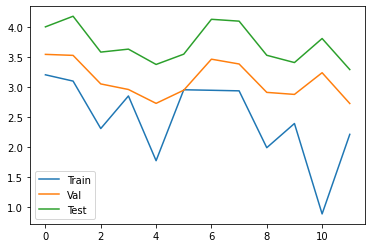

In [68]:


plt.plot(result_df[['RMSE Train', 'RMSE Val', 'RMSE Test']])
plt.legend(('Train', 'Val', 'Test'))
# columns=('n_epochs', 'nh', 'learning_rate', 'af', 'RMSE Train', 'RMSE Val', 'RMSE Test'))

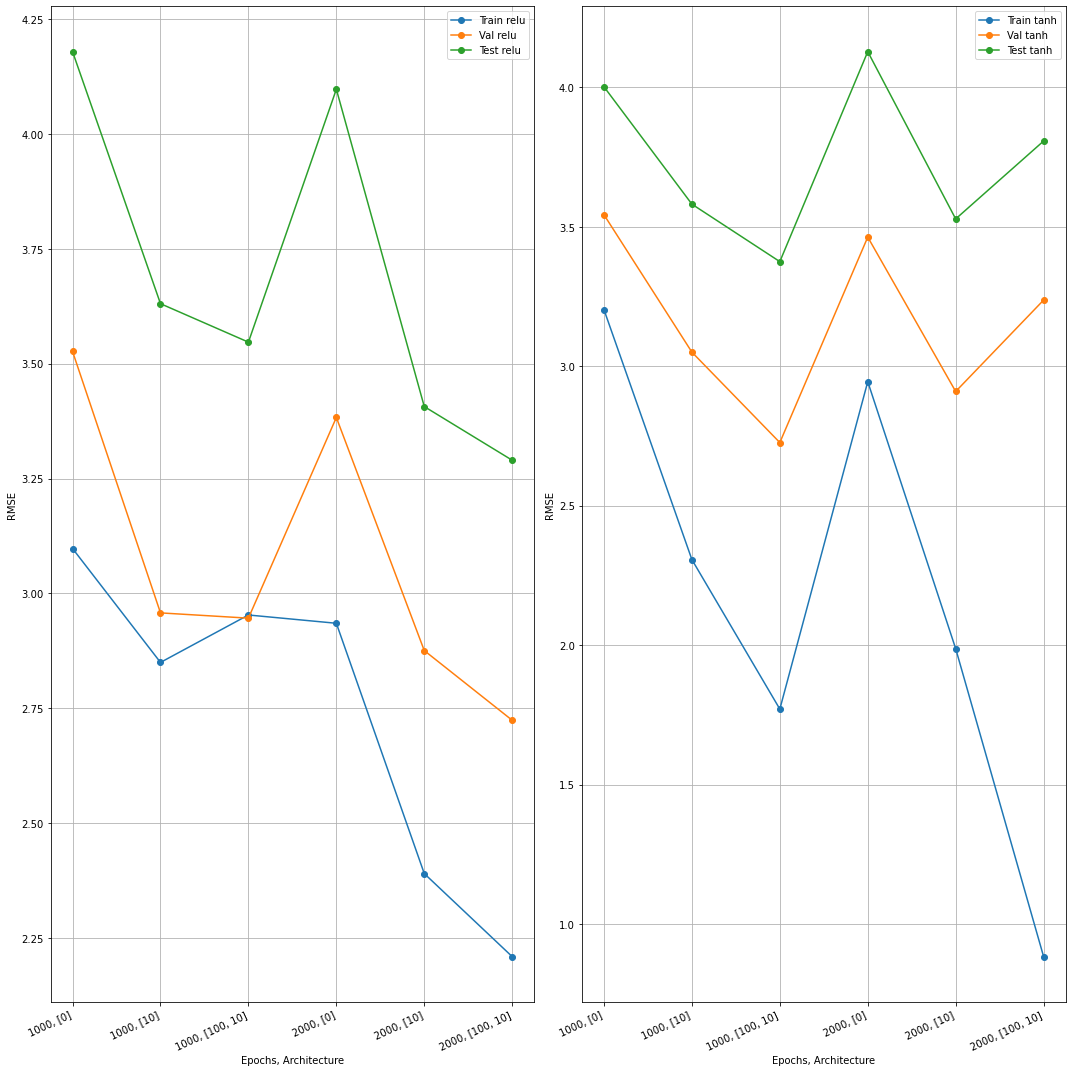

In [75]:

plt.figure(figsize=(15, 15))
df = result_df
#plot two graphs of RMSE on the Y-axis vs. our training durations and architectures on the X-axis

# plot results with relu  on the left
plt.subplot(1, 2, 1)
dfsgd = df[(df['af'] == 'relu')]
xs = range(dfsgd.shape[0])
plt.plot(xs, dfsgd[['RMSE Train', 'RMSE Val', 'RMSE Test']], 'o-')
xticks = dfsgd[['n_epochs', 'nh']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1) # converting to strings
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.xlabel('Epochs, Architecture')
# plt.ylim(0, 7)
plt.ylabel('RMSE')
plt.legend(('Train relu', 'Val relu', 'Test relu'))
plt.grid('on')

# plot results with Adam optimization on the right
plt.subplot(1, 2, 2)
dfadam = df[(df['af'] == 'tanh')]
xs = range(dfadam.shape[0])
plt.plot(xs, dfadam[['RMSE Train', 'RMSE Val', 'RMSE Test']], 'o-')
xticks = dfadam[['n_epochs', 'nh']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1)
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.xlabel('Epochs, Architecture')
# plt.ylim(0, 8)
plt.ylabel('RMSE')
plt.legend(('Train tanh', 'Val tanh', 'Test tanh'))
plt.grid('on')

plt.tight_layout();


Describe at least three different observations you make about these plots.  What do you find interesting?

1. Overall, relu had the best improvement of RMSE over tanh, which is to be expected
2. The spike where n_hidden_units_per_layer_choices is [0] is consistant with almost all of the data
3. tanh has a stronger gradient

## Grading and Check-in

You and your partner will score of 70 points if your functions are defined correctly. You can test this grading process yourself by downloading [A2grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A2grader.zip) and extract `A2grader.py` parallel to this notebook.  We recommend keeping this notebook and the grader script in a dedicated folder with *just those two files.* Run the code in the in the following cell to see an example grading run.  If your functions are defined correctly, you should see a score of 70/70.  The remaining 30 points will be based on 1) other testing and the results you obtain, and 2) your discussions.

In [52]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'A2.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing
  w = np.array([0.0])
  def cubic(wmin):
      return (w[0] - wmin) ** 3 + (w[0] - wmin) ** 2
  def grad_cubic(wmin):
      return 3 * (w[0] - wmin) ** 2 + 2 * (w[0] - wmin)
  wmin = 0.5
  opt = Optimizers(w)
  errors_sgd = opt.sgd(cubic, grad_cubic, [wmin], 100, 0.01)

sgd: Epoch 10 Error=0.11889
sgd: Epoch 20 Error=0.11092
sgd: Epoch 30 Error=0.10176
sgd: Epoch 40 Error=0.09162
sgd: Epoch 50 Error=0.08081
sgd: Epoch 60 Error=0.06972
sgd: Epoch 70 Error=0.05879
sgd: Epoch 80 Error=0.04844
sgd: Epoch 90 Error=0.03901
sgd: Epoch 100 Error=0.03072

--- 10/10 points. Returned correct value.

Testing
  w = np.array([0.0])
  def cubic(wmin):
      return (w[0] - wmin) ** 3 + (w[0] - wmin) ** 2
  def grad_cubic(wmin):
      return 3 * (w[0] - wmin) ** 2 +

Name this notebook as `Lastname1-Lastname2-A2.ipynb`| with Lastname1 being then name of the last name of the person who is turning in the notebook.

A different but similar grading script will be used to grade your checked-in notebook.  It will include different tests.

## Extra Credit: 5 point

Add the Swish activation function as a third choice in your `train` function in your `NeuralNetwork` class.
A little googling will find definitions of it and its gradient.  Start with [this article](https://www.machinecurve.com/index.php/2019/05/30/why-swish-could-perform-better-than-relu/#todays-activation-functions).

Use your `run_experiment` function to compare results for all three activation functions.  Discuss the results.